In [1]:
import pandas as pd
from safegraph_py_functions import safegraph_py_functions as sgpy
import os
from dotenv import load_dotenv, find_dotenv
from loguru import logger

In [2]:
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)
os.chdir(os.environ.get("ROOT_DIR"))
from src import DATA_DIR
raw_data_dir = DATA_DIR / 'raw'

In [3]:
# if import is 0 it reads the data from the existing file
# otherwise reads in the raw data an makes a unified dataset
IMPORT = 0 

In [4]:
# Read in all patterns files in the monthly-patterns folder
def get_files():
    patterns_path = raw_data_dir / "monthly-patterns"
    files = []
    for f in patterns_path.glob("**/*.csv.gz"):
        files.append(f)
    return files

In [5]:
def filter_to_philly(df):
    # zip codes are read as integers rather than strings so we add leading zeros.
    # this is not strictly necessary since Philadelphia zipcodes don't have leading zeros.
    
    # Philadelphia selection
    # HK: adding leading zeros because some zipcodes in MA are 0191X.
    df['postal_code'] = df['postal_code'].apply(lambda x: ('00000'+str(x))[-5:])
    in_philly = df['postal_code'].astype(str).str.startswith("191")
    df = df.loc[in_philly]
    df = df[['safegraph_place_id','date_range_start','postal_code', 
             'raw_visit_counts', 'raw_visitor_counts']]
    
    return df

In [6]:
if IMPORT == 1:
    philly_patterns = []
    files = get_files()
    for i, f in enumerate(files):
        print(f)
        philly_patterns.append(filter_to_philly(pd.read_csv(f)))
    philly_patterns = pd.concat(philly_patterns)
    philly_patterns.to_csv(
    DATA_DIR / "processed" / "kmeans_patterns.csv.tar.gz", index=False
    )
else:
    philly_patterns = pd.read_csv(DATA_DIR / "processed" / "kmeans_patterns.csv.tar.gz")

In [7]:
philly_patterns.head()

,safegraph_place_id,date_range_start,postal_code,raw_visit_counts,raw_visitor_counts
0,sg:26825b56c5ce4c7d91afdc71a7c34440,2020-10-01T00:00:00-04:00,19107,7,7
1,sg:32b17bf96a93444588131370e52d310d,2020-10-01T00:00:00-04:00,19140,168,96
2,sg:3f4865e8bbb249838350eee9a101c8eb,2020-10-01T00:00:00-04:00,19140,75,47
3,sg:76dbefabe6eb465fac98e62c2fb15be9,2020-10-01T00:00:00-04:00,19140,322,234
4,sg:9b2b12ebfa7745b6814873b7c1cef76b,2020-10-01T00:00:00-04:00,19118,93,46


In [8]:
philly_patterns.describe()

,postal_code,raw_visit_counts,raw_visitor_counts
count,366391.000000,366391.000000,366391.000000
mean,19128.629521,278.358898,141.250293
std,15.849648,2008.466906,895.089228
min,19102.000000,1.000000,1.000000
25%,19115.000000,28.000000,17.000000
50%,19130.000000,109.000000,58.000000
75%,19143.000000,267.000000,133.000000
max,19195.000000,235429.000000,99729.000000


In [9]:
philly_patterns['date_range_start'] = philly_patterns['date_range_start'].apply(lambda x : x[:10])
mask = philly_patterns['date_range_start'] < '2020-03-01' 
prepandemic = philly_patterns.loc[mask,].copy()
pandemic = philly_patterns.loc[~mask,].copy()

In [10]:
prepandemic.date_range_start.unique()

array(['2019-03-01', '2019-04-01', '2019-05-01', '2019-02-01',
       '2019-11-01', '2019-10-01', '2019-07-01', '2019-09-01',
       '2019-08-01', '2019-01-01', '2019-06-01', '2019-12-01',
       '2020-02-01', '2020-01-01'], dtype=object)

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [12]:
def cut_outliers(df):
    for col in ['raw_visit_counts', 'raw_visitor_counts']:
        ub = 2*df[col].quantile(0.99)
        mask = df[col] > ub
        df.loc[mask,col] = ub
    return df

def Stdrshp(df): 
    df = df.pivot(index='safegraph_place_id',columns='date_range_start')[['raw_visit_counts', 'raw_visitor_counts']]
    df = df.fillna(0)
    scaled = StandardScaler().fit_transform(df)
    scaled_features_df = pd.DataFrame(scaled, index=df.index, columns=df.columns)
    return scaled_features_df

def make_clusters(df, k = 5):
    kmeans = KMeans(n_clusters=k).fit(df)
    df['cluster'] = kmeans.labels_
    return (df, kmeans.inertia_)

def run_Kmeans(df, k = 5):
    normalized = Stdrshp(cut_outliers(df.copy()))
    return make_clusters(normalized, k)

In [13]:
scaled = Stdrshp(cut_outliers(prepandemic))
n_clusters = [k for k in range(3,13)]
inertias = []
for k in n_clusters:
    df, inertia = make_clusters(scaled, k = k)
    inertias.append(inertia)

In [14]:
import matplotlib.pyplot as plt

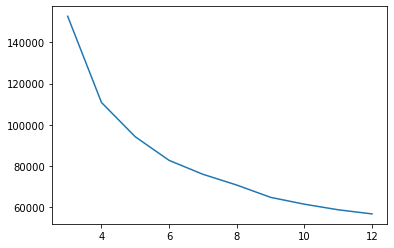

In [15]:
plt.plot(n_clusters,inertias)

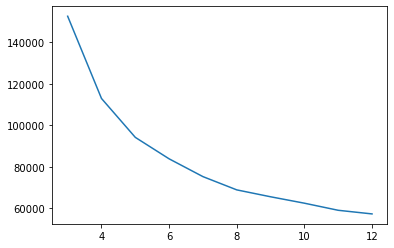

In [16]:
scaled = Stdrshp(prepandemic)
n_clusters = [k for k in range(3,13)]
inertias = []
for k in n_clusters:
    df, inertia = make_clusters(scaled, k = k)
    inertias.append(inertia)
    
plt.plot(n_clusters,inertias)

In [19]:
prepandemic, prepandemic_inertia = run_Kmeans(prepandemic, k = 8)
pandemic, pandemic_inertia = run_Kmeans(pandemic, k = 8)

In [20]:
pandemic_inertia

68813.8791548519

In [21]:
# We want to compare pandemic_inertia to the inertia we would have in 2020 if we used the
# 2019 clustering
combined = pandemic.join(prepandemic[['cluster']], how='left',rsuffix='pre')
combined[['clusterpre']] = combined[['clusterpre']].fillna(value=-1)
combined['clusterpre'] = combined['clusterpre'].astype(int)

In [22]:
cols = combined.columns
cols = cols[:-2]
n = len(combined.columns)

In [26]:
def get_inertia(df, cols, cluster_col):
    mask = df[cluster_col] > -1
    n = len(df.index)
    filtered = df[mask]
    m = len(filtered.index)
    se = ((df[cols] - df.groupby(cluster_col)[cols].transform('mean'))**2).to_numpy().sum()
    return se*(n/m)

get_inertia(combined, cols, 'clusterpre')

191403.44775162882

In [28]:
#worst case scenario
combined['newcol'] = 1
get_inertia(combined, cols, 'newcol')

323136.0

In [29]:
combined.groupby('cluster').size()

cluster
0    11845
1      478
2       69
3     5361
4     2086
5       45
6      211
7      101
dtype: int64

In [31]:
combined.groupby('clusterpre').size()

clusterpre
-1    2407
 0    5271
 1      81
 2    9285
 3     676
 4      30
 5      67
 6    2133
 7     246
dtype: int64